# ABB Project

![800px-ABB_Logo[1].png](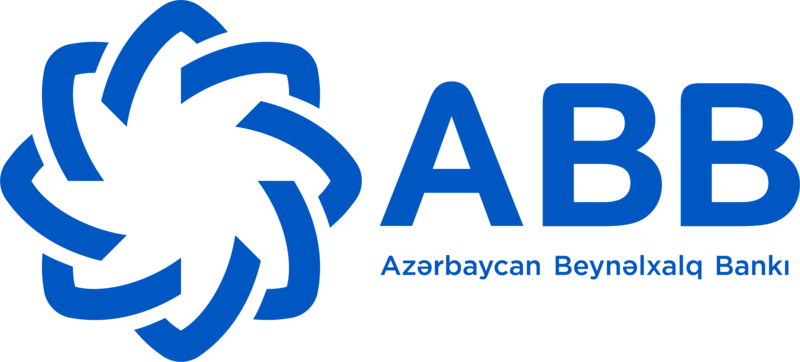)

## Use case

**•** Create ML model from A to Z  with each steps and share jupyter file (.ipynb) for assessment.

**•** We would like to see your own evaluation comments related to each step and not only python scripts.

**•** In dataset Bought-is dependent variable.

**Dataset :** [Bank Customer Estimate Dataset](https://huggingface.co/spaces/riyadahmadov/Bank_Customer_Estimated/blob/main/Python%20examination.xlsx)

## Project Pipeline for Data Scientist


1. **Feature Engineering**:
   - Yeni xüsusiyyətlər yaratmaq: Əlavə anlayışlar verə biləcək yeni dəyişənlər yaradılması.

2. **Imbalance Handle**:
   - Verilənlərdə balanssızlığı aradan qaldırmaq.

3. **Creating Model**:
   - Alqoritmlərdən istifadə edərək maşın öyrənmə təsnifat modelini qurmaq

4. **Creating Class**:
   - Binar təsnifat üçün müxtəlif modellərin qurulması üçün sinif yaratmaq və ən optimal modeli seçmək

5. **Model Deployment**:
   - Ən yaxşı modeli Gradio-da yerləşdirmək

### Feature Engineering & Data Preprocessing

In [548]:
!pip install -U optbinning

In [549]:
!pip install gradio

In [613]:
# Kitabxanaların çağırılması
import warnings as wg
wg.filterwarnings('ignore')

import pandas as pd
import numpy as np
import pickle
from collections import Counter

# Visuallaşma kitabxanaları
import seaborn as sns
import matplotlib.pyplot as plt

# Imbalanced learning
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier

# Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

# VIF score
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Model selection
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, RandomizedSearchCV

# Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer, f1_score

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Optimal Binning
from optbinning import OptimalBinning

# Gradio UI üçün
import gradio as gr

In [559]:
# Data-nın import edilməsi
df = pd.read_csv('/content/bank_data_science_dataset.csv')

In [560]:
# Data type-lara baxaq və model üçün lazımı düzəlişləri edək
print('Data Types: \n',df.dtypes)

# Dəyərləri int-ə çevirək (Label Encoding)
df['Cins'] = df['Cins'].apply(lambda x: 1 if x == 'Kişi' else (0 if x == 'Qadın' else 2))
df['Satın alma'] = df['Satın alma'].apply(lambda x: 1 if x == 'Xidməti alıb' else (0 if x == 'Xidməti almayıb' else 2))
# Note: Telefon sütununu bu metodla etmədim çünki cinsiyyət dəqiq 2 kateqoriyadan biridir. Telefon sütunu üçün digər dəyərlər ola bilər. (PC və.s)

# Həmçinin müştəri column-u silək bu sütun unique dəyərlərdən ibarətdir və model zamanı bizə kömək etməyəcək
del df['Müştəri']

# Telefon sütununu numerik dəyərə çevirək
df = pd.get_dummies(df, columns = ['Telefon'], drop_first=True)
df = df.astype(int)

Data Types: 
 Müştəri                                           int64
Cins                                             object
Əməliyyatların sayı                               int64
ATM əməliyyatları arasında orta gün intervalı     int64
Cari balans                                       int64
Nağd əməliyyatların medianı                       int64
Telefon                                          object
Satın alma                                       object
dtype: object


In [561]:
# Boş dəyərləri ml metodu ilə dolduraq amma fikir verməli olduğumuz məqam correlyasidır. (Əlavə olaraq, imbalance problemi var.)
#    Cins
# 1|	213
# 0|	61
# 2|	39
# Əgər bu problemi həll etmədən doldurmaq istəsək hamısını kişi olaraq dolduracaq.

features = ['Əməliyyatların sayı', 'ATM əməliyyatları arasında orta gün intervalı',
            'Cari balans', 'Nağd əməliyyatların medianı', 'Satın alma',
            'Telefon_IOS', 'Telefon_Məlumat yoxdur']

# Datanı train and test bölək (where 'Cins' == 2)
train = df[df['Cins'] != 2]
test = df[df['Cins'] == 2]

# X_train and y_train
X_train = train[features]
y_train = train['Cins']

# SMOTE metod imbalance handle etmək üçün
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# X_test to predict
X_test = test[features]

# Use Balanced Random Forest Classifier
model = BalancedRandomForestClassifier(random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Predict the 'Cins' column test datası üçün
y_pred = model.predict(X_test)

# Fill the predicted values in the test dataset
df.loc[df['Cins'] == 2, 'Cins'] = y_pred

y_train_pred = model.predict(X_train)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97        61
           1       1.00      0.99      0.99       213

    accuracy                           0.99       274
   macro avg       0.97      0.98      0.98       274
weighted avg       0.99      0.99      0.99       274



In [562]:
# Optimal dağılımlı sütunların yaradılması
def create_binning_column(df, column_name, target_column, suffix="_aralıq"):
    optbin = OptimalBinning(name=column_name, dtype="numerical")
    optbin.fit(df[column_name], df[target_column])
    binning_table = optbin.binning_table.build()
    df[column_name + suffix] = optbin.transform(df[column_name], metric="bins")
    return binning_table

columns_to_bin = ['Əməliyyatların sayı', 'ATM əməliyyatları arasında orta gün intervalı', 'Cari balans', 'Nağd əməliyyatların medianı']
binning_tables = {}

for column in columns_to_bin:
    binning_table = create_binning_column(df, column, 'Satın alma')
    binning_tables[column] = binning_table

with open('binning_tables.pkl', 'wb') as file:
    pickle.dump(binning_tables, file)

with open('binning_tables.pkl', 'rb') as file:
    loaded_binning_tables = pickle.load(file)

In [565]:
# Bin and label dictionary-nin yaradılması (deploy-da map t kimi istifadə edəcik)
data_dict = {
    'Əməliyyatların sayı': {
        'bin': [-float('inf'), 17.50, 197.50, 321.50, 766.00, 1152.50, 2774.50, float('inf')],
        'label': ['(-inf, 17.50)', '[17.50, 197.50)', '[197.50, 321.50)', '[321.50, 766.00)', '[766.00, 1152.50)', '[1152.50, 2774.50)', '[2774.50, inf)']
    },
    'ATM əməliyyatları arasında orta gün intervalı': {
        'bin': [-float('inf'), 1.00, 3.50, 4.50, 6.50, 8.50, 12.50, float('inf')],
        'label': ['(-inf, 1.00)', '[1.00, 3.50)', '[3.50, 4.50)', '[4.50, 6.50)', '[6.50, 8.50)', '[8.50, 12.50)', '[12.50, inf)']
    },
    'Cari balans': {
        'bin': [-float('inf'), 0.50, 5.50, 552.50, 1422.00, 2763.00, 10647.50, float('inf')],
        'label': ['(-inf, 0.50)', '[0.50, 5.50)', '[5.50, 552.50)', '[552.50, 1422.00)', '[1422.00, 2763.00)', '[2763.00, 10647.50)', '[10647.50, inf)']
    },
    'Nağd əməliyyatların medianı': {
        'bin': [-float('inf'), 2.00, 62.50, 159.00, 271.00, 600.00, 1383.50, float('inf')],
        'label': ['(-inf, 2.00)', '[2.00, 62.50)', '[62.50, 159.00)', '[159.00, 271.00)', '[271.00, 600.00)', '[600.00, 1383.50)', '[1383.50, inf)']
    }
}

In [566]:
# Dəyərlərin label encoding edilməsi
def label_binning(df, column_name):
    unique_bins = sorted(df[column_name].unique())
    bin_labels = {bin_val: idx for idx, bin_val in enumerate(unique_bins)}
    df[column_name] = df[column_name].map(bin_labels)
    return bin_labels

columns_to_label = ['Əməliyyatların sayı_aralıq', 'ATM əməliyyatları arasında orta gün intervalı_aralıq', 'Cari balans_aralıq', 'Nağd əməliyyatların medianı_aralıq']

label_maps = {}
for column in columns_to_label:
    label_map = label_binning(df, column)
    label_maps[column] = label_map

In [567]:
# Mövcud məlumat hədlərindən istifadə edərək yeni məlumat hədlərinin yaradılması

# 1. Əməliyyat tezliyi: Müştərinin ATM əməliyyatları arasındakı orta gün intervalına görə əməliyyat etmə tezliyini əks etdirir.
df['Transaction_Frequency'] = df['Əməliyyatların sayı'] / df['ATM əməliyyatları arasında orta gün intervalı']

# 2. Nağd əməliyyat intensivliyi: Müştərinin balansının nə qədər hissəsinin nağd əməliyyatlar üçün istifadə edildiyini ölçür.
df['Cash_Transaction_Intensity'] = df['Nağd əməliyyatların medianı'] / df['Cari balans']
# !!! Amma bu dəqiq olmaya bilər çünki müştərinin cari balansı dəyişən faktordur.

# 3. ATM asılılığı: Müştərinin ümumi əməliyyat sayına görə ATM-lərə nə qədər bağlı olduğunu göstərir.
df['ATM_Dependency'] = df['Əməliyyatların sayı'] * df['ATM əməliyyatları arasında orta gün intervalı']

# 4. Əməliyyat intensivliyi: Yüksək sayda əməliyyat aparan müştəriləri ön plana çıxarır.
df['Transaction_Intensity'] = df['Əməliyyatların sayı'] * df['Nağd əməliyyatların medianı']

# 5. ATM və nağd əməliyyat üstünlüyü: Müştərinin nağd əməliyyatlara digər əməliyyat növləri üzərində üstünlük verdiyini göstərir.
df['ATM_Cash_Preference'] = df['Nağd əməliyyatların medianı'] / df['Əməliyyatların sayı']

# Sonsuz dəyərləri olan sütunları tapın
infinite_columns = df.columns[np.isinf(df).any(axis=0)]


infinite_values = {}
# Sonsuz dəyərləri median ilə əvəzləyin
for column in infinite_columns:
    median_value = df[column][~np.isinf(df[column])].median()
    infinite_values[column] = median_value
    df[column].replace([float('inf'), float('-inf')], median_value, inplace=True)

null_values = {}
# NaN dəyərləri median ilə əvəzləyin
for column in df.select_dtypes(include=[np.number]).columns:
    if df[column].isna().any():
        median_value1 = df[column].median()
        null_values[column] = median_value1
        df[column].fillna(median_value1, inplace=True)

In [568]:
# Korrelyasiyaya baxaq:
df.corr()['Satın alma']

,Satın alma
Cins,0.254324
Əməliyyatların sayı,-0.081127
ATM əməliyyatları arasında orta gün intervalı,-0.074299
Cari balans,0.088166
Nağd əməliyyatların medianı,-0.107698
Satın alma,1.000000
Telefon_IOS,-0.220418
Telefon_Məlumat yoxdur,0.307573
Əməliyyatların sayı_aralıq,-0.203568
ATM əməliyyatları arasında orta gün intervalı_aralıq,-0.139729


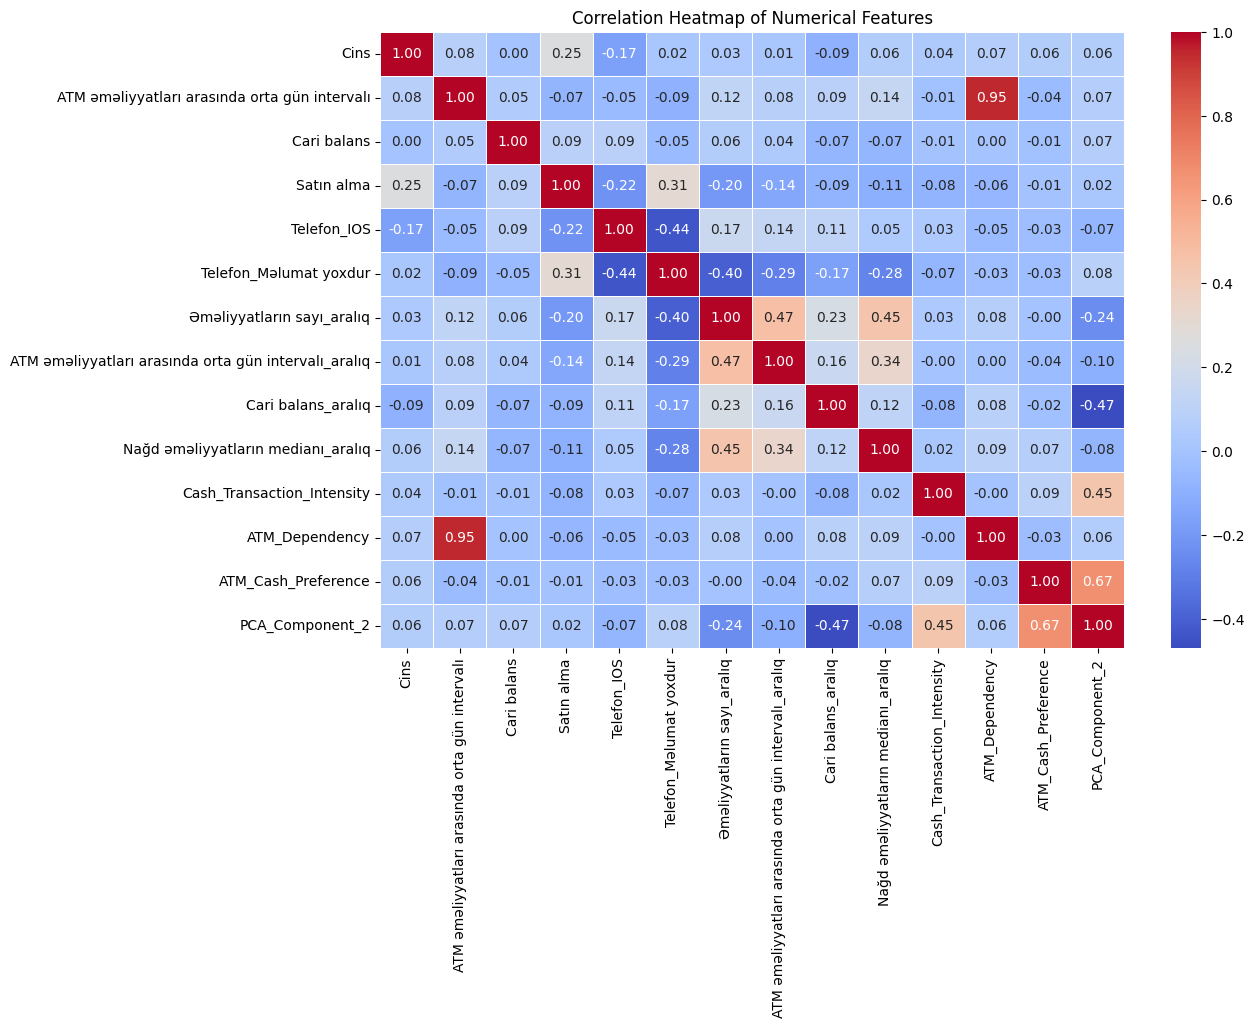

In [612]:
# Məlumat hədləri arasında korrelyasiya
plt.figure(figsize=(12, 8))
corr = df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

In [569]:
# İlk olaraq korrelyasiyalar üçün threshold təyin edirik. 0.1
# Yerdə qalan sütunları atmaq doğru olmaz çünki onlarında modelə qatqısını sağlamaq lazımdır
# Düşünürəm ki, dimesion reduction edə bilərik və əsas faktorları özündə saxlayan 1 - 2 sütun create edə bilərik.
correlation = df.corr()['Satın alma']

# Korrelasiya dəyərlərini filtr edək
filtered_columns = correlation[(correlation.abs() < 0.1)].index.tolist()

# df-dən bu sütunları seçək
filtered_df = df[filtered_columns]

# standartlaşdırma
scaler = StandardScaler()
scaled_data = scaler.fit_transform(filtered_df)

# PCA tətbiq edək, yalnız 2 komponent saxlayacağıq
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_data)

# PCA komponentlərini DataFrame-ə çevirək
pca_df = pd.DataFrame(data=pca_components, columns=['PCA_Component_1', 'PCA_Component_2'])

# Orijinal DataFrame ilə birləşdirək
df_with_pca = pd.concat([df.reset_index(drop=True), pca_df], axis=1)

# Scaler pickle kimi saxlanılması
scaler_filename = 'standard_scaler_pca.pkl'
with open(scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)

# Saving the PCA model
pca_filename = 'pca_model.pkl'
with open(pca_filename, 'wb') as file:
    pickle.dump(pca, file)

# Nəticələri baxaq
print("Filtered Columns:\n", filtered_columns)
print("PCA Components Shape:", pca_df.shape)

PCA model saved successfully.
Filtered Columns:
 ['Əməliyyatların sayı', 'ATM əməliyyatları arasında orta gün intervalı', 'Cari balans', 'Cari balans_aralıq', 'Transaction_Frequency', 'Cash_Transaction_Intensity', 'ATM_Dependency', 'Transaction_Intensity', 'ATM_Cash_Preference']
PCA Components Shape: (313, 2)


In [570]:
# Final data frame
df = df_with_pca.copy()

In [571]:
# Multicollenarity üçün vif scoruna baxaq
X = df.drop('Satın alma', axis=1)
X = X.select_dtypes(include=[np.number])

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the VIF scores
print(vif_data)

                                              Feature       VIF
0                                                Cins  1.062977
1                                 Əməliyyatların sayı       inf
2       ATM əməliyyatları arasında orta gün intervalı       inf
3                                         Cari balans       inf
4                         Nağd əməliyyatların medianı  2.051494
5                                         Telefon_IOS  1.337120
6                              Telefon_Məlumat yoxdur  1.570584
7                          Əməliyyatların sayı_aralıq  2.101487
8   ATM əməliyyatları arasında orta gün intervalı_...  1.477550
9                                  Cari balans_aralıq       inf
10                 Nağd əməliyyatların medianı_aralıq  1.417099
11                              Transaction_Frequency       inf
12                         Cash_Transaction_Intensity       inf
13                                     ATM_Dependency       inf
14                              Transact

In [572]:
# Aralarınma min 0.5 corr olmaq şərti ilə sütunları silək
correlation_matrix = df.corr()
columns_to_delete = []

for x in df.columns:
    for y in df.columns:
        if x != y and abs(correlation_matrix[x][y]) > 0.5:
            if correlation_matrix[x]['Satın alma'] > correlation_matrix[y]['Satın alma']:
                columns_to_delete.append(y)
                print(f'{y} Column deleted...')
            else:
                columns_to_delete.append(x)
                print(f'{x} Column deleted...')
            break

columns_to_delete = list(set(columns_to_delete))
columns_to_delete
df.drop(columns=columns_to_delete, inplace=True)

print("Updated DataFrame:")
print(df.head())

Əməliyyatların sayı Column deleted...
Əməliyyatların sayı Column deleted...
Nağd əməliyyatların medianı Column deleted...
Transaction_Frequency Column deleted...
Əməliyyatların sayı Column deleted...
Transaction_Intensity Column deleted...
Nağd əməliyyatların medianı Column deleted...
PCA_Component_1 Column deleted...
Transaction_Frequency Column deleted...
Updated DataFrame:
   Cins  ATM əməliyyatları arasında orta gün intervalı  Cari balans  \
0     1                                              3        10618   
1     1                                              0          483   
2     1                                              2         7031   
3     1                                             25           -1   
4     1                                              3         6680   

   Satın alma  Telefon_IOS  Telefon_Məlumat yoxdur  \
0           1            0                       1   
1           1            0                       1   
2           1            0      

### Imbalance Handle

In [573]:
# Target sütun etiketləri arasında balansı yoxlanılması
df['Satın alma'].value_counts()

,count
Satın alma,
0,247
1,66


In [574]:
# Input və Target dəyərlərin təyin edilməsi
X = df.drop(['Satın alma'], axis = 1 )
y = df['Satın alma']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Balanced Random Forest (Way 1)

In [575]:
# Balanced Random Forest üsulu ilə nəticəyə baxılması
balanced_rf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)

balanced_rf.fit(X_train, y_train)

y_pred_balanced_rf = balanced_rf.predict(X_test)

print("Classification Report for Balanced Random Forest:")
print(classification_report(y_test, y_pred_balanced_rf))

Classification Report for Balanced Random Forest:
              precision    recall  f1-score   support

           0       0.92      0.71      0.80        49
           1       0.44      0.79      0.56        14

    accuracy                           0.73        63
   macro avg       0.68      0.75      0.68        63
weighted avg       0.81      0.73      0.75        63



#### SMOTE + Tomek Links (Way 2)

In [576]:
# SMOTE + Tomek Links methodundan istifadə edərək yeni dəyərin yaradılması
smote_tomek = SMOTETomek(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)

print(f"Class distribution after SMOTE + Tomek Links: {Counter(y_resampled)}")

Class distribution after SMOTE + Tomek Links: Counter({0: 170, 1: 170})


In [577]:
# Yeni Data Frame quraq
resampled_df = pd.concat([X_resampled, y_resampled], axis=1)

#### Random Undersampling (Way 3)

In [510]:
# Düşünürəm ki, bu method-da tamlıq qorunmuş olur. Çünki digər methodlarda biz yeni datalar generasiya etdik, bu method-da isə random olaraq məlumatı azaltdıq.(Amma təhlil üçün əlimizdə az datanın qalması faktorunu da nəzərə almalıyıq)
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

print(f"Class distribution after Random Undersampling: {Counter(y_resampled)}")

Class distribution after Random Undersampling: Counter({0: 41, 1: 41})


In [511]:
resampled_df = pd.concat([X_resampled, y_resampled], axis=1)

### Creating Model

In [578]:
X = resampled_df.drop('Satın alma', axis=1)
y = resampled_df['Satın alma']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
}

results = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    results[model_name] = accuracy

    print(f"{model_name} Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, predictions))
    print(confusion_matrix(y_test, predictions))

print("\nAll Model Accuracies:")
for model_name, score in results.items():
    print(f"{model_name}: {score:.4f}")

Logistic Regression Accuracy: 0.7647
              precision    recall  f1-score   support

           0       0.74      0.82      0.78        34
           1       0.80      0.71      0.75        34

    accuracy                           0.76        68
   macro avg       0.77      0.76      0.76        68
weighted avg       0.77      0.76      0.76        68

[[28  6]
 [10 24]]
Decision Tree Accuracy: 0.7500
              precision    recall  f1-score   support

           0       0.77      0.71      0.74        34
           1       0.73      0.79      0.76        34

    accuracy                           0.75        68
   macro avg       0.75      0.75      0.75        68
weighted avg       0.75      0.75      0.75        68

[[24 10]
 [ 7 27]]
Random Forest Accuracy: 0.8088
              precision    recall  f1-score   support

           0       0.78      0.85      0.82        34
           1       0.84      0.76      0.80        34

    accuracy                           0.81  

In [579]:
# Hypertuning üçün Random search istifadə edilməsi
param_grids = {
    "Gradient Boosting": {
        'n_estimators': [50, 100, 150, 200, 300, 500],
        'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
        'max_depth': [3, 4, 5, 6, 7, 8],
        'subsample': [0.7, 0.8, 0.9, 1.0],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "XGBoost": {
        'n_estimators': [50, 100, 150, 200, 300, 500],
        'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
        'max_depth': [3, 4, 5, 6, 7, 8],
        'subsample': [0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
        'gamma': [0, 0.1, 0.3, 0.5, 1.0]
    },
    "Random Forest": {
        'n_estimators': [100, 200, 300, 400, 500],
        'max_depth': [None, 10, 20, 30, 40, 50],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }
}

models = {
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Random Forest": RandomForestClassifier()
}

In [580]:
# Modellərə görə uyğun parametrin tapılması
best_models = {}
best_scores = {}

for model_name, model in models.items():
    print(f"Performing Random Search for {model_name}...")

    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grids[model_name],
        n_iter=10,
        cv=3,
        verbose=1,
        scoring='accuracy',
        random_state=42
    )
    random_search.fit(X_train, y_train)

    best_models[model_name] = random_search.best_estimator_
    best_scores[model_name] = random_search.best_score_

    print(f"Best Parameters for {model_name}: {random_search.best_params_}")
    print(f"Best Score for {model_name}: {random_search.best_score_:.4f}")

best_model_name = max(best_scores, key=best_scores.get)
best_model = best_models[best_model_name]

print(f"\nBest Model Overall: {best_model_name} with score {best_scores[best_model_name]:.4f}")

Performing Random Search for Gradient Boosting...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters for Gradient Boosting: {'subsample': 1.0, 'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.3}
Best Score for Gradient Boosting: 0.8566
Performing Random Search for XGBoost...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters for XGBoost: {'subsample': 0.9, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.9}
Best Score for XGBoost: 0.8420
Performing Random Search for Random Forest...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters for Random Forest: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 20, 'bootstrap': False}
Best Score for Random Forest: 0.8493

Best Model Overall: Gradient Boosting with score 0.8566


In [581]:
# Random forest modelinin tətbiq edilməsi və cv texnikinin icrası (overfit hadisəsinin testi üçün)
X = resampled_df.drop('Satın alma', axis=1)
y = resampled_df['Satın alma']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)

print(f"Random Forest Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, predictions))
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score, average='weighted')
}

cv_results = cross_validate(model, X, y, cv=5, scoring=scoring, return_train_score=True)

print("\nCross-Validation Results:")
for metric in scoring.keys():
    print(f"Mean {metric.capitalize()} (Train): {np.mean(cv_results[f'train_{metric}']):.4f}")
    print(f"Mean {metric.capitalize()} (Test): {np.mean(cv_results[f'test_{metric}']):.4f}")

print("\nIndividual Fold Results:")
for i in range(cv_results['test_accuracy'].shape[0]):
    print(f"Fold {i+1} - Accuracy: {cv_results['test_accuracy'][i]:.4f}, F1-Score: {cv_results['test_f1'][i]:.4f}")

Random Forest Accuracy: 0.8529
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.86        34
           1       0.88      0.82      0.85        34

    accuracy                           0.85        68
   macro avg       0.85      0.85      0.85        68
weighted avg       0.85      0.85      0.85        68

Confusion Matrix:
[[30  4]
 [ 6 28]]

Cross-Validation Results:
Mean Accuracy (Train): 0.9794
Mean Accuracy (Test): 0.8471
Mean F1 (Train): 0.9794
Mean F1 (Test): 0.8466

Individual Fold Results:
Fold 1 - Accuracy: 0.7206, F1-Score: 0.7200
Fold 2 - Accuracy: 0.9559, F1-Score: 0.9559
Fold 3 - Accuracy: 0.8529, F1-Score: 0.8528
Fold 4 - Accuracy: 0.8676, F1-Score: 0.8676
Fold 5 - Accuracy: 0.8382, F1-Score: 0.8365


### Creating Class

In [583]:
# Müxtəlif modelləri quran həmçinin sınaqdan keçirən və ən optimal modeli seçən class-ın yazılması
class find_thebest_model:
    def __init__(self, models=None, scoring='accuracy', cv=5):
        if models is None:
            self.models = {
                    "Logistic Regression": LogisticRegression(),
                    "Decision Tree": DecisionTreeClassifier(),
                    "Random Forest": RandomForestClassifier(),
                    "Gradient Boosting": GradientBoostingClassifier(),
                    "AdaBoost": AdaBoostClassifier(),
                    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
            }
        else:
            self.models = models
        self.scoring = scoring
        self.cv = cv
        self.best_model = None
        self.best_score = -np.inf

    def fit(self, X, y):
        for model_name, model in self.models.items():
            scores = cross_val_score(model, X, y, cv=self.cv, scoring=self.scoring)
            mean_score = np.mean(scores)
            print(f"{model_name} - Mean {self.scoring.capitalize()}: {mean_score:.4f}")
            if mean_score > self.best_score:
                self.best_score = mean_score
                self.best_model = model_name
        print(f"\nBest Model: {self.best_model} with {self.scoring.capitalize()}: {self.best_score:.4f}")

    def predict(self, X_test):
        model = self.models[self.best_model]
        model.fit(X, y)
        return model.predict(X)

    def get_best_model(self):
        return self.models[self.best_model]

In [584]:
X = resampled_df.drop('Satın alma', axis=1)
y = resampled_df['Satın alma']

optimizer = find_thebest_model(scoring='f1')
optimizer.fit(X, y)
predictions = optimizer.predict(X_test)
best_model = optimizer.get_best_model()

print(f"The best model is: {best_model}")

Logistic Regression - Mean F1: 0.6898
Decision Tree - Mean F1: 0.8358
Random Forest - Mean F1: 0.8516
Gradient Boosting - Mean F1: 0.8733
AdaBoost - Mean F1: 0.8199
XGBoost - Mean F1: 0.8457

Best Model: Gradient Boosting with F1: 0.8733
The best model is: GradientBoostingClassifier()


### Model Development

In [585]:
# Modelin pickle file kimi save olunması
X = resampled_df.drop(['Satın alma'], axis=1)
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)
X_standardized_df = pd.DataFrame(X_standardized, columns=X.columns)

# Store mean and standard deviation for manual standardization later
mean = scaler.mean_
std = scaler.scale_

# Scaler pickle kimi saxlanılması
scaler_filename = 'standard_scaler.pkl'
with open(scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)

# Print mean and standard deviation for reference
print("Mean:", mean)
print("Standard Deviation:", std)

X = X_standardized_df
y = resampled_df['Satın alma']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Display classification report
y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Save the model as a pickle file
model_filename = 'random_forest_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)

Mean: [8.91176471e-01 7.71764706e+00 2.69613588e+04 2.41176471e-01
 3.55882353e-01 2.28235294e+00 1.77647059e+00 2.99411765e+00
 2.01176471e+00 1.60855200e+01 1.04151647e+05 1.10347342e+00
 1.11795068e-01]
Standard Deviation: [3.11417676e-01 2.79585246e+01 2.14854397e+05 4.27797126e-01
 4.78779807e-01 2.06432877e+00 1.66540206e+00 1.79540937e+00
 2.25437675e+00 1.18160157e+02 7.94802980e+05 2.52628842e+00
 9.09671442e-01]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.88      0.85        34
           1       0.87      0.79      0.83        34

    accuracy                           0.84        68
   macro avg       0.84      0.84      0.84        68
weighted avg       0.84      0.84      0.84        68



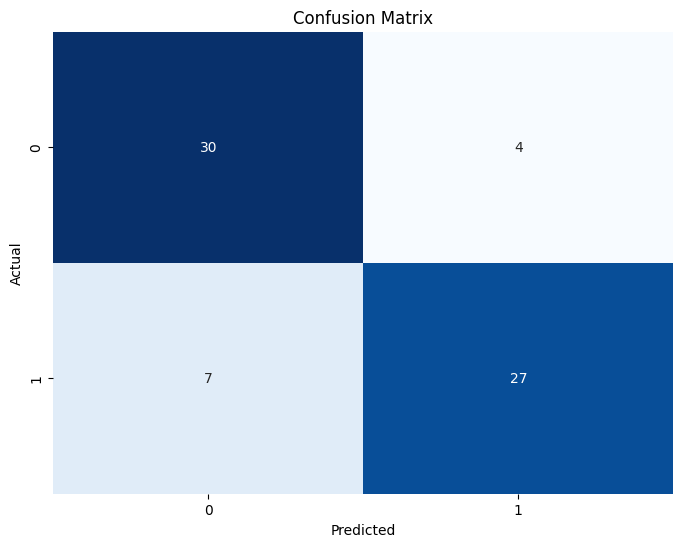

In [614]:
# Vizual olaraq confusion mat baxaq
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [608]:
# Bir funksiyada bütün əməliyyatların icra olunması
def predict(Müştəri, Cins, Əməliyyatların_sayı, ATM_əməliyyatları_arasında_orta_gün_intervalı, Cari_balans,Nağd_əməliyyatların_medianı, Telefon):

    with open('standard_scaler.pkl', 'rb') as file:
        loaded_scaler = pickle.load(file)
    with open('standard_scaler_pca.pkl', 'rb') as file:
        loaded_scaler_pca = pickle.load(file)
    with open('random_forest_model.pkl', 'rb') as file:
        model = pickle.load(file)
    with open('pca_model.pkl', 'rb') as file:
        pca_model = pickle.load(file)

    # Prepare input data
    input_data = np.array([[Müştəri, Cins, Əməliyyatların_sayı, ATM_əməliyyatları_arasında_orta_gün_intervalı, Cari_balans,Nağd_əməliyyatların_medianı, Telefon]])
    input_data = pd.DataFrame(input_data, columns=['Müştəri', 'Cins', 'Əməliyyatların sayı', 'ATM əməliyyatları arasında orta gün intervalı', 'Cari balans', 'Nağd əməliyyatların medianı', 'Telefon'])
    df = input_data.copy()

    # Dəyərləri int-ə çevirək (Label Encoding)
    df['Cins'] = df['Cins'].apply(lambda x: 1 if x == 'Kişi' else (0 if x == 'Qadın' else 2))

    # Həmçinin müştəri column-u silək bu sütun unique dəyərlərdən ibarətdir və model zamanı bizə kömək etməyəcək
    del df['Müştəri']

    # Telefon sütununu numerik dəyərə çevirək
    conditions = [
        (df['Telefon'] == 'IOS'),
        (df['Telefon'] == 'Məlumat yoxdur')
    ]

    # Corresponding values for each condition
    ios_values = [1, 0]
    melumat_values = [0, 1]

    df['Telefon_IOS'] = np.select(conditions, ios_values, default=0)
    df['Telefon_Məlumat yoxdur'] = np.select(conditions, melumat_values, default=0)
    del df['Telefon']
    df = df.astype('int')

    columns_to_bin = ['Əməliyyatların sayı', 'ATM əməliyyatları arasında orta gün intervalı', 'Cari balans', 'Nağd əməliyyatların medianı']
    binning_tables = {}

    # bin and label
    for col in columns_to_bin:
        bin_labels = data_dict[col]['label']
        bin_edges = data_dict[col]['bin']

        binned_col_name = f"{col}_aralıq"
        df[binned_col_name] = pd.cut(df[col], bins=bin_edges, labels=bin_labels, right=False)
        df[binned_col_name] = df[binned_col_name].map(label_maps[binned_col_name])

    # new features
    df = df.astype('int')
    df['Transaction_Frequency'] = df['Əməliyyatların sayı'] / df['ATM əməliyyatları arasında orta gün intervalı']
    df['Cash_Transaction_Intensity'] = df['Nağd əməliyyatların medianı'] / df['Cari balans']
    df['ATM_Dependency'] = df['Əməliyyatların sayı'] * df['ATM əməliyyatları arasında orta gün intervalı']
    df['Transaction_Intensity'] = df['Əməliyyatların sayı'] * df['Nağd əməliyyatların medianı']
    df['ATM_Cash_Preference'] = df['Nağd əməliyyatların medianı'] / df['Əməliyyatların sayı']

    infinite_columns = df.columns[np.isinf(df).any(axis=0)]
    for column in infinite_columns:
        df[column].replace([float('inf'), float('-inf')], infinite_values[column], inplace=True)
    for column in df.select_dtypes(include=[np.number]).columns:
        if df[column].isna().any():
            df[column].fillna(null_values[column], inplace=True)

    filtered_columns = ['Əməliyyatların sayı',
    'ATM əməliyyatları arasında orta gün intervalı',
    'Cari balans',
    'Cari balans_aralıq',
    'Transaction_Frequency',
    'Cash_Transaction_Intensity',
    'ATM_Dependency',
    'Transaction_Intensity',
    'ATM_Cash_Preference']

    filtered_df = df[filtered_columns]

    # standartlaşdırma
    scaled_data = loaded_scaler_pca.fit_transform(filtered_df)

    # PCA tetbiqi
    pca_components = pca_model.transform(scaled_data)
    pca_df = pd.DataFrame(data=pca_components, columns=['PCA_Component_1', 'PCA_Component_2'])
    df = pd.concat([df.reset_index(drop=True), pca_df], axis=1)

    columns_to_delete = ['Nağd əməliyyatların medianı','Transaction_Intensity','Əməliyyatların sayı','PCA_Component_1','Transaction_Frequency']
    df.drop(columns = columns_to_delete, inplace = True)


    for i, col in enumerate(df.columns):
      df[col] = (df[col] - mean[i]) / std[i]

    # print(df)
    prediction = model.predict(df)
    probability = model.predict_proba(df)
    result = 'Aldı' if prediction[0] == 1 else 'Almadı'

    if result == 'Aldı':
        prob = probability[0][1]
    else:
        prob = probability[0][0]

    if result == 'Aldı':
        result = 'alacaq.'
    else:
        result = 'almayacaq.'

    answer = f"Id-si {Müştəri} olan müştəri {int(round(prob*100,2))}% ehtimalla məhsulu {result}"

    return answer

In [609]:
# Nümunə üçun almış müştərini yoxlayaq
predict(17, 'Məlumat yoxdur', 464, 6, 368, 273, 'IOS')

'Id-si 17 olan müştəri 58% ehtimalla məhsulu alacaq.'

### Deploy in Gradio

In [610]:
import pickle
import numpy as np
import pandas as pd
import gradio as gr


mean = np.array([8.91176471e-01, 7.71764706e+00, 2.69613588e+04, 2.41176471e-01,
       3.55882353e-01, 2.28235294e+00, 1.77647059e+00, 2.99411765e+00,
       2.01176471e+00, 1.60855200e+01, 1.04151647e+05, 1.10347342e+00,
       1.11795068e-01])

std = np.array([3.11417676e-01, 2.79585246e+01, 2.14854397e+05, 4.27797126e-01,
       4.78779807e-01, 2.06432877e+00, 1.66540206e+00, 1.79540937e+00,
       2.25437675e+00, 1.18160157e+02, 7.94802980e+05, 2.52628842e+00,
       9.09671442e-01])

# Define the function to make predictions
def predict(Müştəri, Cins, Əməliyyatların_sayı, ATM_əməliyyatları_arasında_orta_gün_intervalı, Cari_balans, Nağd_əməliyyatların_medianı, Telefon):
    # Load pre-trained models and scalers
    with open('standard_scaler.pkl', 'rb') as file:
        loaded_scaler = pickle.load(file)
    with open('standard_scaler_pca.pkl', 'rb') as file:
        loaded_scaler_pca = pickle.load(file)
    with open('random_forest_model.pkl', 'rb') as file:
        model = pickle.load(file)
    with open('pca_model.pkl', 'rb') as file:
        pca_model = pickle.load(file)

    # Prepare input data
    input_data = np.array([[Müştəri, Cins, Əməliyyatların_sayı, ATM_əməliyyatları_arasında_orta_gün_intervalı, Cari_balans, Nağd_əməliyyatların_medianı, Telefon]])
    input_data = pd.DataFrame(input_data, columns=['Müştəri', 'Cins', 'Əməliyyatların sayı', 'ATM əməliyyatları arasında orta gün intervalı', 'Cari balans', 'Nağd əməliyyatların medianı', 'Telefon'])
    df = input_data.copy()

    # Dəyərləri int-ə çevirək (Label Encoding)
    df['Cins'] = df['Cins'].apply(lambda x: 1 if x == 'Kişi' else (0 if x == 'Qadın' else 2))

    # Həmçinin müştəri column-u silək
    del df['Müştəri']

    # Telefon sütununu numerik dəyərə çevirək
    conditions = [
        (df['Telefon'] == 'IOS'),
        (df['Telefon'] == 'Məlumat yoxdur')
    ]

    # Corresponding values for each condition
    ios_values = [1, 0]
    melumat_values = [0, 1]

    # Apply values based on the conditions
    df['Telefon_IOS'] = np.select(conditions, ios_values, default=0)
    df['Telefon_Məlumat yoxdur'] = np.select(conditions, melumat_values, default=0)
    del df['Telefon']
    df = df.astype('int')

    # Binning and mapping
    columns_to_bin = ['Əməliyyatların sayı', 'ATM əməliyyatları arasında orta gün intervalı', 'Cari balans', 'Nağd əməliyyatların medianı']
    # Assuming you have data_dict and label_maps defined somewhere
    for col in columns_to_bin:
        bin_labels = data_dict[col]['label']
        bin_edges = data_dict[col]['bin']

        binned_col_name = f"{col}_aralıq"
        df[binned_col_name] = pd.cut(df[col], bins=bin_edges, labels=bin_labels, right=False)
        df[binned_col_name] = df[binned_col_name].map(label_maps[binned_col_name])

    df = df.astype('int')
    df['Transaction_Frequency'] = df['Əməliyyatların sayı'] / df['ATM əməliyyatları arasında orta gün intervalı']
    df['Cash_Transaction_Intensity'] = df['Nağd əməliyyatların medianı'] / df['Cari balans']
    df['ATM_Dependency'] = df['Əməliyyatların sayı'] * df['ATM əməliyyatları arasında orta gün intervalı']
    df['Transaction_Intensity'] = df['Əməliyyatların sayı'] * df['Nağd əməliyyatların medianı']
    df['ATM_Cash_Preference'] = df['Nağd əməliyyatların medianı'] / df['Əməliyyatların sayı']

    # Replace infinite values and fill nulls (assuming infinite_values and null_values are defined)
    infinite_columns = df.columns[np.isinf(df).any(axis=0)]
    for column in infinite_columns:
        df[column].replace([float('inf'), float('-inf')], infinite_values[column], inplace=True)
    for column in df.select_dtypes(include=[np.number]).columns:
        if df[column].isna().any():
            df[column].fillna(null_values[column], inplace=True)

    # Filter columns
    filtered_columns = [
        'Əməliyyatların sayı',
        'ATM əməliyyatları arasında orta gün intervalı',
        'Cari balans',
        'Cari balans_aralıq',
        'Transaction_Frequency',
        'Cash_Transaction_Intensity',
        'ATM_Dependency',
        'Transaction_Intensity',
        'ATM_Cash_Preference'
    ]

    filtered_df = df[filtered_columns]

    # Standardization
    scaled_data = loaded_scaler_pca.fit_transform(filtered_df)

    # Apply PCA transformation
    pca_components = pca_model.transform(scaled_data)
    pca_df = pd.DataFrame(data=pca_components, columns=['PCA_Component_1', 'PCA_Component_2'])


    df = pd.concat([df.reset_index(drop=True), pca_df], axis=1)

    # Multicolinar olan sütunları silək
    columns_to_delete = ['Nağd əməliyyatların medianı','Transaction_Intensity','Əməliyyatların sayı','PCA_Component_1','Transaction_Frequency']
    df.drop(columns = columns_to_delete, inplace = True)

    # Standart scaler
    for i, col in enumerate(df.columns):
      df[col] = (df[col] - mean[i]) / std[i]

    # Prediction
    prediction = model.predict(df)
    probability = model.predict_proba(df)
    result = 'Aldı' if prediction[0] == 1 else 'Almadı'
    if result == 'Aldı':
        prob = probability[0][1]
    else:
        prob = probability[0][0]

    if result == 'Aldı':
        result = 'alacaq.'
    else:
        result = 'almayacaq.'

    answer = f"Id-si {Müştəri} olan müştəri {int(round(prob*100,2))}% ehtimalla məhsulu {result}"

    return {answer}


# Define Gradio interface
iface = gr.Interface(
    fn=predict,
    inputs=[
        gr.Slider(minimum=1, maximum=1000000, label="Müştəri"),
        gr.Radio(choices=['Kişi', 'Qadın'], label="Cins"),
        gr.Slider(minimum=0, maximum=10000, label="Əməliyyatların sayı"),
        gr.Slider(minimum=0, maximum=365, label="ATM əməliyyatları arasında orta gün intervalı"),
        gr.Slider(minimum=-100000, maximum=1000000, label="Cari balans"),
        gr.Slider(minimum=0, maximum=10000, label="Nağd əməliyyatların medianı"),
        gr.Radio(choices=['Məlumat yoxdur', 'ANDROID', 'IOS'], label="Telefon")
    ],
    outputs="json",
    title="Müştəri Satınalma Proqnozu",
    description="Bu tətbiq müştərinin satınalma ehtimalını proqnozlaşdırır."
)

iface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://60122cbc5ed3aaff20.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


![800px-ABB_Logo[1].png](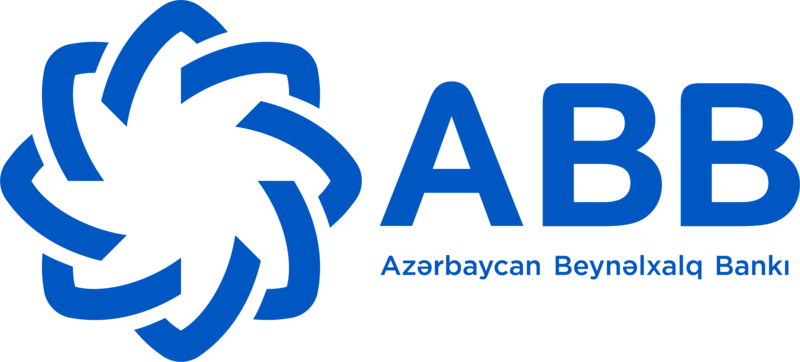)